[ 개발 주제 : 체중 범위 예측 모델 ]
- 데이터셋 : eat.csv
 * 피쳐/특성/데이터 : Gender, Age, Height, Weight, family_history_with_overweight
 * 타겟/정답/레이블 : Nobeyesdad
- 학습종류 : 지도학습 - 분류 
- 알고리즘 : 데이터셋 분석 후 결정 

< 1. 모듈 및 파일 로딩 > <hr>

In [1492]:
# [1-1] 모듈 로딩
import pandas as pd                                     # 데이터 관련 모듈
import numpy as np                                      # 배열 관련 모듈
from sklearn.model_selection import train_test_split    # Train / Test 분리
from sklearn.linear_model import LogisticRegression     # 로지스틱 회귀 모듈
import matplotlib.pyplot as plt                         # 시각화 모듈
import koreanize_matplotlib                             # 한글화 모듈 
import seaborn as sns                                   # 시각화 모듈 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler  # 스케일링 모듈
from sklearn.metrics import precision_score, recall_score, f1_score           # 분류용 성능지표 모듈
from sklearn.metrics import classification_report, confusion_matrix           # 분류용 성능지표 모듈
from sklearn.metrics import log_loss                                          # 손실 계산 모듈 
from sklearn.model_selection import cross_validate                            # 교차 검증 모듈
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder # 인코딩 모듈 
from function import checkModel

In [1493]:
import graphviz
from sklearn.tree import DecisionTreeClassifier # 모델 클래스
from sklearn.tree import export_graphviz        # 모델 시각화 

In [1494]:
# [1-2] 데이터 로딩
obesity_df = pd.read_excel('eat.xlsx')

In [1495]:
# [1-3] 데이터 기본 정보 확인
obesity_df.info()

# 각 컬럼의 내용 
'''
Gender - 남성(0) 여성(1)
Age - 나이
Height - 미터 단위의 키
Weight - 킬로그램 단위의 체중.
family_history_with_overweight - 해당 사람의 비만 가족력 (예(1), 아니요(0))
Nobeyesdad – 비만 수준(저체중(0), 정상체중(1), 과체중(2), 비만(3))
'''

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   int64  
 1   Age                             2111 non-null   int64  
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   int64  
 5   NObeyesdad                      2111 non-null   object 
dtypes: float64(2), int64(3), object(1)
memory usage: 99.1+ KB


'\nGender - 남성(0) 여성(1)\nAge - 나이\nHeight - 미터 단위의 키\nWeight - 킬로그램 단위의 체중.\nfamily_history_with_overweight - 해당 사람의 비만 가족력 (예(1), 아니요(0))\nNobeyesdad – 비만 수준(저체중(0), 정상체중(1), 과체중(2), 비만(3))\n'

< 2. 데이터 전처리 > <hr>

In [1496]:
# [2-1] 데이터 결측치 확인
# 기본정보 확인 결과, 결측치 없음 

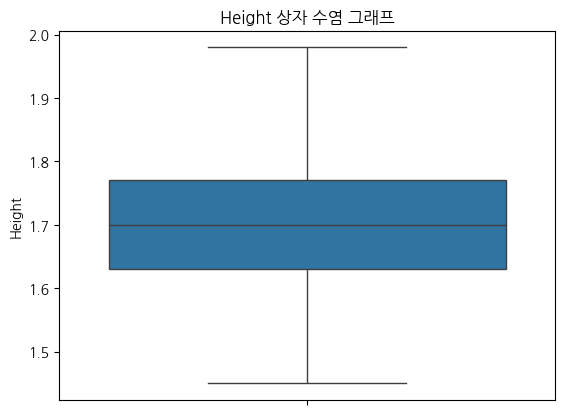

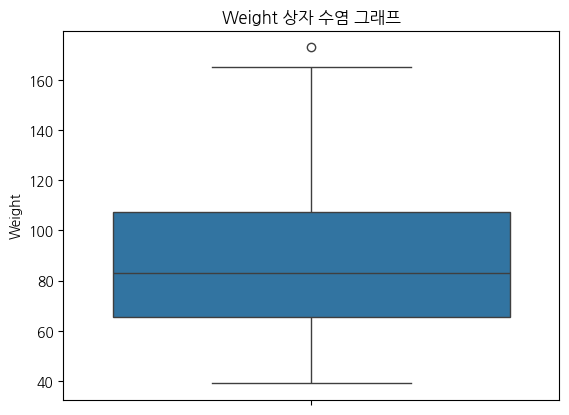

In [1497]:
# [2-2] 데이터 이상치 확인 

# 박스 플롯으로 시각화
idx_list = ['Height', 'Weight']
for i in idx_list:
    sns.boxplot(obesity_df[i])
    plt.title(f'{i} 상자 수염 그래프')
    plt.savefig("graph.png", dpi=300, transparent=True)
    plt.show()


In [1498]:
# [2-3] 이상치 제거
obesity_df = obesity_df[obesity_df['Weight'] <= 160]

In [1499]:
pd.set_option('future.no_silent_downcasting',True)
labelToNum={'Insufficient_Weight': 0, 
    'Normal_Weight': 1, 
    'Overweight_Level_I': 2, 
    'Overweight_Level_II': 3, 
    'Obesity_Type_I': 4, 
    'Obesity_Type_II': 5, 
    'Obesity_Type_III': 6}
# 안전한 레이블 변환
obesity_df['NObeyesdad'] = obesity_df['NObeyesdad'].map(labelToNum)

# 변환이 잘 되었는지 확인
print(obesity_df['NObeyesdad'].unique())  # [0 1 2 3 4 5 6]이 출력되어야 함

[1 2 3 4 0 5 6]


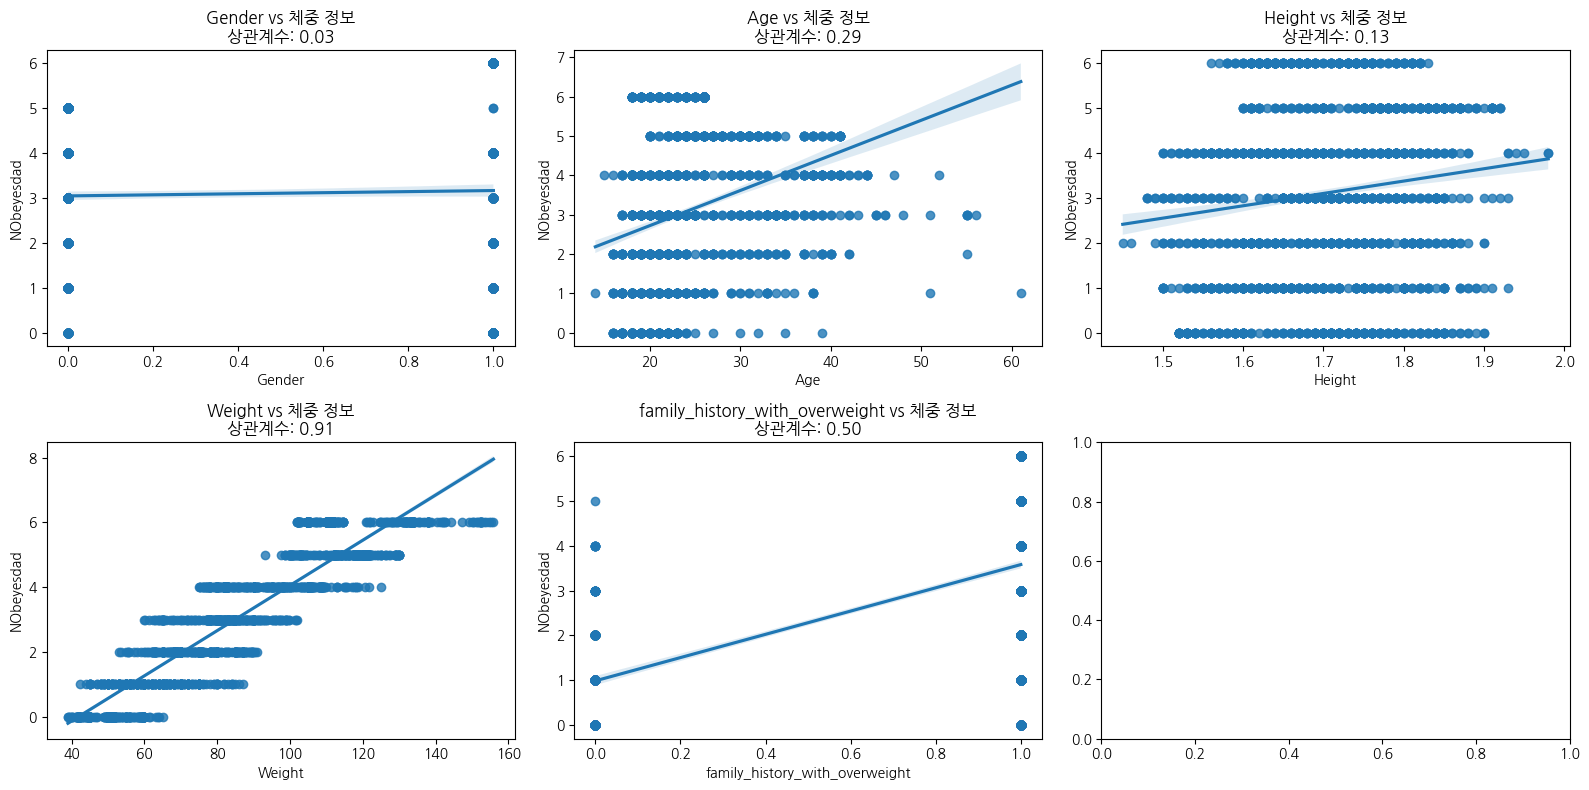

In [1500]:
# [2-4] 탐색적 분석 - 시각화
fig, axs = plt.subplots(figsize=(16,8), ncols=3, nrows=2)
features = ['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight']

# i는 인덱스, feature는 list안의 원소 하나씩 반환 
for i, feature in enumerate(features):
    row = int(i/3)
    col = i % 3
    
    # seaborn 'regplot' 활용해서 산점도와 선형 회귀 직선을 함께 표현 
    sns.regplot(x=feature, y='NObeyesdad', data=obesity_df, ax=axs[row][col])
    
    # 피처와 타겟 간 상관계수 계산
    correlation = np.corrcoef(obesity_df[feature].astype(float), obesity_df['NObeyesdad'].astype(float))[0, 1]
    
    # 제목에 상관계수 포함
    axs[row][col].set_title(f"{feature} vs 체중 정보\n상관계수: {correlation:.2f}")
    
plt.tight_layout()
plt.savefig("graph.png", dpi=300, transparent=True)
plt.show()


In [1501]:
# [2-5] 탐색적 분석 - 상관계수
obesity_df.corr()['NObeyesdad']

Gender                            0.030139
Age                               0.286559
Height                            0.129464
Weight                            0.914644
family_history_with_overweight    0.504966
NObeyesdad                        1.000000
Name: NObeyesdad, dtype: float64

< 3. 데이터 가공 > <hr>

In [1502]:
# [3-1] 데이터 형변환 

obesity_df['Gender'] = obesity_df['Gender'].astype('category')
obesity_df['family_history_with_overweight'] = obesity_df['family_history_with_overweight'].astype('category')

obesity_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2107 entries, 0 to 2110
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   Gender                          2107 non-null   category
 1   Age                             2107 non-null   int64   
 2   Height                          2107 non-null   float64 
 3   Weight                          2107 non-null   float64 
 4   family_history_with_overweight  2107 non-null   category
 5   NObeyesdad                      2107 non-null   int64   
dtypes: category(2), float64(2), int64(2)
memory usage: 86.7 KB


In [1503]:
# [3-2] 피쳐 / 타겟 분리
featureDF = obesity_df[['Gender', 'Age', 'Weight', 'Height', 'family_history_with_overweight']]   # 피쳐
targetSR = obesity_df.NObeyesdad                                                                  # 타겟

In [1504]:
# [3-3] 훈련용 / 테스트용 분리 
# 분류 시에는 훈련용 / 테스트용에 동일한 비율로 타겟이 배분 
# ( stratify = 타겟 ) 매개변수 : 타겟 데이터셋의 클래스/라벨 비율에 맞게 학습용, 테스트용 분리 
train_X, test_X, train_y, test_y = train_test_split(featureDF, targetSR,
                                                    random_state=42,
                                                    test_size=0.2,
                                                    stratify=targetSR)

In [1505]:
# [3-4] 스케일링 

# 스케일링할 열만 선택
columns_to_scale = ['Weight', 'Height']

# 스케일러 초기화 및 fit
scaler = StandardScaler()
scaler.fit(train_X[columns_to_scale])

# 스케일링된 열을 transform
train_scaled = scaler.transform(train_X[columns_to_scale])
test_scaled = scaler.transform(test_X[columns_to_scale])

# 스케일링되지 않은 열 유지
train_other_cols = train_X.drop(columns=columns_to_scale)
test_other_cols = test_X.drop(columns=columns_to_scale)

# 스케일링된 열을 데이터프레임으로 변환
train_scaled_df = pd.DataFrame(train_scaled, columns=columns_to_scale, index=train_X.index)
test_scaled_df = pd.DataFrame(test_scaled, columns=columns_to_scale, index=test_X.index)

In [1506]:
# [3-5] 인코딩 
from sklearn.preprocessing import OneHotEncoder
hot = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# 인코딩할 범주형 피쳐 선택
categorical_features = ['Gender', 'Age', 'family_history_with_overweight']

# 범주형 데이터를 OneHotEncoding 실행
encoded_categorical = hot.fit(train_X[categorical_features])

# 범주형 열 transform 및 데이터프레임 변환
train_encoded = hot.transform(train_X[categorical_features])
test_encoded = hot.transform(test_X[categorical_features])

# 인코딩된 열을 데이터프레임으로 변환
encoded_columns = hot.get_feature_names_out(categorical_features)
train_encoded_df = pd.DataFrame(train_encoded, columns=encoded_columns, index=train_X.index)
test_encoded_df = pd.DataFrame(test_encoded, columns=encoded_columns, index=test_X.index)

In [1507]:
# 스케일링한 열과 인코딩한 열 병합
train_X = pd.concat([train_scaled_df, train_encoded_df], axis=1)
test_X = pd.concat([test_scaled_df, test_encoded_df], axis=1)

In [1508]:
print(train_X.head())
print(test_X.head())

        Weight    Height  Gender_0  Gender_1  Age_15  Age_16  Age_17  Age_18  \
1733  1.342400  0.869926       1.0       0.0     0.0     0.0     0.0     0.0   
1568  1.340067  0.869926       1.0       0.0     0.0     0.0     0.0     0.0   
770  -0.714085 -0.959397       1.0       0.0     0.0     0.0     0.0     0.0   
2080  1.824929  0.439497       0.0       1.0     0.0     0.0     0.0     1.0   
1335  1.041840  1.730784       1.0       0.0     0.0     0.0     0.0     0.0   

      Age_19  Age_20  ...  Age_46  Age_47  Age_48  Age_51  Age_52  Age_55  \
1733     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
1568     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
770      0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
2080     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
1335     1.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   

      Age_56  Age_61  family_history_with_overweight_0  

In [1509]:
## LabelEncoder : 
lencoder = LabelEncoder()
lencoder.fit(targetSR)
print(lencoder.classes_)

[0 1 2 3 4 5 6]


< 4. 학습 > <hr>

In [1510]:
# [4-1] 학습 진행
# max_depth=5 : depth 조정 
dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_model.fit(train_X, train_y)

DecisionTreeClassifier(max_depth=5, random_state=42)

In [1511]:
# 학습 모델 시각화 파일 저장
export_graphviz(dt_model, 
                out_file='fat_tree.dot',
                feature_names=train_X.columns,
                class_names=train_y.unique().astype(str), 
                filled=True, rounded=True, special_characters=True)

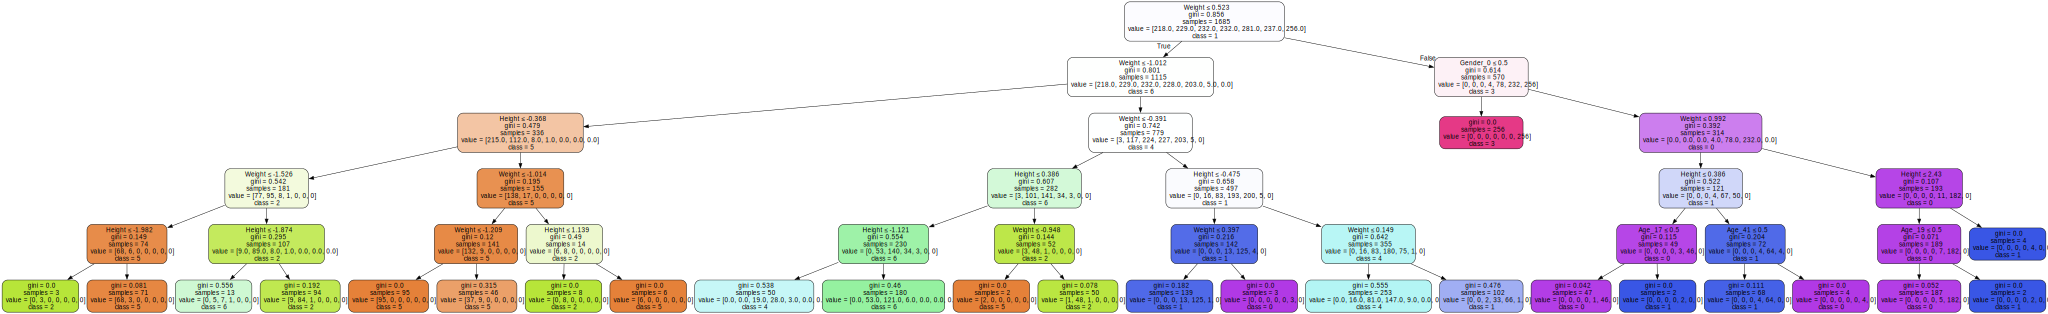

In [1512]:
# 모델 파일 dot => 시각화 

# 파일 열기 (with as 구문 활용 파일 자동 닫힘)
with open('fat_tree.dot') as f:
    data = f.read()
    
# 파일에서 가져온 데이터 시각화 
graphviz.Source(data)

< 5. 성능평가 > <hr>

In [1513]:
##  훈련용 성능과 테스트용 성능평가
## [5-1] 모델의 성능평가 메서드 : score()  accuracy로 성능평가 결과 반환
train_score = dt_model.score(train_X, train_y)
test_score = dt_model.score(test_X, test_y)

print(f'[Train] score : {train_score},  [Test] score : {test_score}')

# 새로운 데이터프레임 생성
score_df = pd.DataFrame({'Set': ['Train', 'Test'], 'Score': [train_score, test_score]})

# 데이터프레임 출력
display(score_df)


[Train] score : 0.8356083086053413,  [Test] score : 0.8056872037914692


,Set,Score
0,Train,0.835608
1,Test,0.805687


In [1514]:
## [5-2] 다양한 성능평가 지표 
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

print('[TRAIN]------------------------')
train_pre = dt_model.predict(train_X)

print(f'정확도 : {accuracy_score(train_y, train_pre)}')
print(f'정밀도 : {precision_score(train_y, train_pre, average="macro")}')
print(f'재현율 : {recall_score(train_y, train_pre, average="macro")}')
print(f'f1점수 : {f1_score(train_y, train_pre, average="macro")}')

[TRAIN]------------------------
정확도 : 0.8356083086053413
정밀도 : 0.8447945875585477
재현율 : 0.8303030447900042
f1점수 : 0.8305691664787439


In [1515]:
print('[TEST]------------------------')
test_pre = dt_model.predict(test_X)

print(f'정확도 : {accuracy_score(test_y, test_pre) }')
print(f'정밀도 : {precision_score(test_y, test_pre, average="macro") }')
print(f'재현율 : {recall_score(test_y, test_pre, average="macro") }')
print(f'f1점수 : {f1_score(test_y, test_pre, average="macro") }')

[TEST]------------------------
정확도 : 0.8056872037914692
정밀도 : 0.8112029655778381
재현율 : 0.7998149451351422
f1점수 : 0.7998046397693261


In [1516]:
## [5-3] 손실/비용 계산 => 확률값으로 
from sklearn.metrics import log_loss
proba = dt_model.predict_proba(train_X)
probatest = dt_model.predict_proba(test_X)

train_loss = log_loss(train_y, proba)
test_loss = log_loss(test_y, probatest)

print(f'[Train Loss] {train_loss}  [Test Loss] {test_loss}')

# 새로운 데이터프레임 생성
score_df = pd.DataFrame({'Set': ['Train', 'Test'], 'Loss': [train_loss, test_loss]})

# 데이터프레임 출력
display(score_df)

[Train Loss] 0.4064594476145397  [Test Loss] 0.6211460443137847


,Set,Loss
0,Train,0.406459
1,Test,0.621146


< 6. 교차검증 > <hr>

In [1517]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [1518]:
# 하이퍼파라미터 dict 생성
param = {'max_depth' : [i for i in range(2,9)], 'criterion' : ['gini', 'entropy', 'log_loss'],
         'min_samples_split': [10, 20],  # 분할 최소 샘플 수
        'min_samples_leaf': [5, 10],  # 리프 노드 최소 샘플 수
        'class_weight': [None, 'balanced']} # 데이터 불균형 처리

# 모델 인스턴스 생성
t_model = DecisionTreeClassifier(random_state=42)

# 교차검증과 튜닝 진행 인스턴스 생성
gridCV = GridSearchCV(t_model, param, scoring=('accuracy'), refit='True')

In [1519]:
gridCV.fit(train_X, train_y)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'class_weight': [None, 'balanced'],
                         'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [2, 3, 4, 5, 6, 7, 8],
                         'min_samples_leaf': [5, 10],
                         'min_samples_split': [10, 20]},
             refit='True', scoring='accuracy')

In [1520]:
# 교차 검증 및 튜닝 후 결과
print(f'가장 좋은 성능의 cv 번호 : {gridCV.best_index_}')
print(f'가장 좋은 성능의 하이퍼파라미터 조합 : {gridCV.best_params_}')
print(f'가장 좋은 성능의 점수 : {gridCV.best_score_}')
print(f'가장 좋은 성능의 재학습된 모델객체 : {gridCV.best_estimator_}')

가장 좋은 성능의 cv 번호 : 136
가장 좋은 성능의 하이퍼파라미터 조합 : {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 5, 'min_samples_split': 10}
가장 좋은 성능의 점수 : 0.9341246290801186
가장 좋은 성능의 재학습된 모델객체 : DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=8, min_samples_leaf=5, min_samples_split=10,
                       random_state=42)


In [1521]:
# 가장 좋은 모델
best_model = gridCV.best_estimator_

In [ ]:
# Decision Tree의 모델 파라미터 : 피쳐 중요도 확인 
for f_name, f_importances in zip(train_X.columns, best_model.feature_importances_):
    print(f_name, f_importances)

Weight 0.6674108160975762
Height 0.20498732827845478
Gender_0 0.0
Gender_1 0.12111351176537517
Age_15 0.0
Age_16 0.0
Age_17 0.0
Age_18 0.0005482942988757637
Age_19 0.0
Age_20 2.9209118627874065e-18
Age_21 0.001066719473012293
Age_22 0.0
Age_23 0.0
Age_24 0.0
Age_25 0.0
Age_26 1.7137559832995433e-15
Age_27 0.0
Age_28 0.0
Age_29 0.0
Age_30 0.0
Age_31 0.0
Age_32 0.0
Age_33 0.0
Age_34 0.0
Age_35 0.0
Age_36 0.0
Age_37 0.0
Age_38 9.388250460576024e-18
Age_39 0.0
Age_40 0.0
Age_41 0.0
Age_42 0.0
Age_43 0.0
Age_44 0.0
Age_45 0.0
Age_46 0.0
Age_47 0.0
Age_48 0.0
Age_51 0.0
Age_52 0.0
Age_55 0.0
Age_56 0.0
Age_61 0.0
family_history_with_overweight_0 0.0034786996871139743
family_history_with_overweight_1 0.0013946303995900618


In [1523]:
## 모델의 성능평가 메서드 : score()  accuracy로 성능평가 결과 반환
train_score = best_model.score(train_X, train_y)
test_score = best_model.score(test_X, test_y)

print(f'[Train] score : {train_score},  [Test] score : {test_score}')

# 새로운 데이터프레임 생성
score_df = pd.DataFrame({'Set': ['Train', 'Test'], 'Score': [train_score, test_score]})

# 데이터프레임 출력
display(score_df)

[Train] score : 0.9667655786350149,  [Test] score : 0.9407582938388626


,Set,Score
0,Train,0.966766
1,Test,0.940758


In [1524]:
## 손실/비용 계산 => 확률값으로 
proba = gridCV.best_estimator_.predict_proba(train_X)
probatest = gridCV.best_estimator_.predict_proba(test_X)

train_loss = log_loss(train_y, proba)
test_loss = log_loss(test_y, probatest)

print(f'[Train Loss] {train_loss}  [Test Loss] {test_loss}')

# 새로운 데이터프레임 생성
score_df = pd.DataFrame({'Set': ['Train', 'Test'], 'Loss': [train_loss, test_loss]})

# 데이터프레임 출력
display(score_df)

[Train Loss] 0.06587637631003838  [Test Loss] 0.7653561772000694


,Set,Loss
0,Train,0.065876
1,Test,0.765356


In [1525]:
print('[TEST]------------------------')
test_pre = best_model.predict(test_X)

print(f'정확도 : {accuracy_score(test_y, test_pre) }')
print(f'정밀도 : {precision_score(test_y, test_pre, average="macro") }')
print(f'재현율 : {recall_score(test_y, test_pre, average="macro") }')
print(f'f1점수 : {f1_score(test_y, test_pre, average="macro") }')

[TEST]------------------------
정확도 : 0.9407582938388626
정밀도 : 0.9402948984986705
재현율 : 0.9382620481142648
f1점수 : 0.9390139492994584


In [1526]:
print('[TRAIN]------------------------')
train_pre = best_model.predict(train_X)

print(f'정확도 : {accuracy_score(train_y, train_pre)}')
print(f'정밀도 : {precision_score(train_y, train_pre, average="macro")}')
print(f'재현율 : {recall_score(train_y, train_pre, average="macro")}')
print(f'f1점수 : {f1_score(train_y, train_pre, average="macro")}')

[TRAIN]------------------------
정확도 : 0.9667655786350149
정밀도 : 0.9673741769809912
재현율 : 0.9656906674241473
f1점수 : 0.9661544550452786


< 7. 예측 > <hr>

In [1527]:
# [7-1] 예측
features = ['Gender', 'Age', 'Weight', 'Height', 'family_history_with_overweight']

print("다음과 같은 순서로 데이터 입력 : ", features)
data_input = input("콤마를 붙여 입력해 주세요 : ")  # Example input: "1, 34, 68, 1.75, 1"

new_data = pd.DataFrame([list(data_input.split(','))], columns=features)

# 1
# 스케일링할 열만 선택
columns_to_scale = ['Weight', 'Height']

# 스케일링된 열을 transform
data_scaled = scaler.transform(new_data[columns_to_scale])

# 스케일링되지 않은 열 유지
data_other_cols = new_data.drop(columns=columns_to_scale)

# 스케일링된 열을 데이터프레임으로 변환
data_scaled_df = pd.DataFrame(data_scaled, columns=columns_to_scale, index=new_data.index)

# 2
# 인코딩할 범주형 피쳐 선택
categorical_features = ['Gender', 'Age', 'family_history_with_overweight']


# 범주형 열 transform 및 데이터프레임 변환
data_encoded = hot.transform(new_data[categorical_features])

# 인코딩된 열을 데이터프레임으로 변환
encoded_columns = encoded_categorical.get_feature_names_out(categorical_features)
data_encoded_df = pd.DataFrame(data_encoded, columns=encoded_columns, index=new_data.index)

new_data = pd.concat([data_scaled_df, data_encoded_df], axis=1)

# 예측 
label_map = {
    0: "저체중",
    1: "정상체중",
    2: "과체중 1단계",
    3: "과체중 2단계",
    4: "경도 비만",
    5: "중등도 비만",
    6: "고도비만"
}

# 예측 실행
prediction = gridCV.best_estimator_.predict(new_data)

# 숫자 값을 대응하는 문자열로 변환
prediction_label = label_map[prediction[0]]

# 최종 결과 출력
print(f"예측 결과: {prediction_label}")

다음과 같은 순서로 데이터 입력 :  ['Gender', 'Age', 'Weight', 'Height', 'family_history_with_overweight']
예측 결과: 저체중
